# Adversarial Discriminative Domain Adaptation for Gaussian Domains
Adaptation of this [paper](https://arxiv.org/pdf/1702.05464.pdf) for inverting a shift between two normally distributed datasets.
The tensorflow code is inspired by [this implementation of a GAN](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

### Source domain

In [3]:
N_source = 100

In [4]:
mean = [-1, 0]

std = 0.1
cov = np.eye(2) * std

In [5]:
x, y = np.random.multivariate_normal(mean, cov, N_source).T
X_source = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Target domain

In [6]:
N_target = 100

In [7]:
mean = [1, 0]

std = 0.1
cov = np.eye(2) * std

In [8]:
x, y = np.random.multivariate_normal(mean, cov, N_target).T
X_target = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Display the dataset

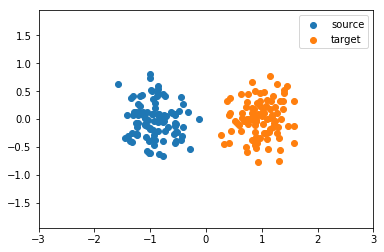

In [9]:
plt.axis("equal")
plt.axis([-3,3,-3,3])

plt.scatter(X_source[:,0], X_source[:,1], label="source")
plt.scatter(X_target[:,0], X_target[:,1], label="target")
plt.legend()

## Create the model

### Placeholders

In [10]:
S_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_source')
T_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_target')

### Discriminator Network

In [11]:
initializer = tf.contrib.layers.xavier_initializer()

with tf.variable_scope("discriminator", reuse=None):
    D_W1 = tf.get_variable('W1', shape=[2,10], initializer=initializer)
    D_b1 = tf.get_variable('b1', shape=[10], initializer=initializer)

    D_W2 = tf.get_variable('W2', shape=[10, 10], initializer=initializer)
    D_b2 = tf.get_variable('b2', shape=[10], initializer=initializer)

    D_W3 = tf.get_variable('W3', shape=[10, 1], initializer=initializer)
    D_b3 = tf.get_variable('b3', shape=[1], initializer=initializer)

In [12]:
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [13]:
def discriminator_nn(x):  
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

### Transformer Network

In [14]:
with tf.variable_scope("generator", reuse=None):
    G_W1 = tf.get_variable('W1', initializer=tf.eye(2, dtype="float32"))
    G_b1 = tf.get_variable('b1', shape=[2], initializer=tf.zeros_initializer())

In [15]:
theta_G = [G_W1, G_b1]

In [16]:
def generator_nn(x):  
    G_output = tf.matmul(x, G_W1) + G_b1
    
    return G_output

### Losses and solver

In [27]:
G_output = generator_nn(S_input)
D_source, D_logit_source = discriminator_nn(G_output)
D_target, D_logit_target = discriminator_nn(T_input)

In [28]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

In [29]:
D_loss = -tf.reduce_mean(log(D_target) + log(1. - D_source))
G_loss = -tf.reduce_mean(log(D_source))

In [30]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [31]:
from tensorflow.python.ops.losses import losses
from tensorflow.python.ops.losses import util
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

def wasserstein_generator_loss(discriminator_gen_outputs,
                               weights=1.0,
                               scope=None,
                               loss_collection=ops.GraphKeys.LOSSES,
                               reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS):

    with ops.name_scope(scope, 'generator_wasserstein_loss', (discriminator_gen_outputs, weights)) as scope:
        discriminator_gen_outputs = math_ops.to_float(discriminator_gen_outputs)

        loss = - discriminator_gen_outputs
        loss = losses.compute_weighted_loss(loss, weights, scope, loss_collection, reduction)

    return loss


def wasserstein_discriminator_loss(discriminator_real_outputs,
                                   discriminator_gen_outputs,
                                   real_weights=1.0,
                                   generated_weights=1.0,
                                   scope=None,
                                   loss_collection=ops.GraphKeys.LOSSES,
                                   reduction=losses.Reduction.SUM_BY_NONZERO_WEIGHTS):
  
    with ops.name_scope(scope, 'discriminator_wasserstein_loss', (
    discriminator_real_outputs, discriminator_gen_outputs, real_weights, generated_weights)) as scope:
        discriminator_real_outputs = math_ops.to_float(discriminator_real_outputs)
        discriminator_gen_outputs = math_ops.to_float(discriminator_gen_outputs)
        discriminator_real_outputs.shape.assert_is_compatible_with(discriminator_gen_outputs.shape)

        loss_on_generated = losses.compute_weighted_loss(
            discriminator_gen_outputs, generated_weights, scope,
            loss_collection=None, reduction=reduction)
                                            
        loss_on_real = losses.compute_weighted_loss(
            discriminator_real_outputs, real_weights, scope, loss_collection=None,
            reduction=reduction)
                                            
        loss = loss_on_generated - loss_on_real
                                            
        util.add_loss(loss, loss_collection)

    return loss

In [32]:
# D_loss = wasserstein_discriminator_loss(D_target, D_source)
# G_loss = wasserstein_generator_loss(D_source)
# D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
# G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

## Execute the model

In [41]:
sess = tf.InteractiveSession()

In [42]:
sess.run(tf.global_variables_initializer())
D_loss_list = []
G_loss_list = []
iter_list = []

In [106]:
nb_iter = 500
nb_iter_d = 10
nb_iter_g = 2
nb_samples = 40
G_loss_curr = 0.001
D_loss_curr = 0.001

for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={S_input: sample_source})
    
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        _, D_loss_curr = sess.run([D_solver, D_loss],feed_dict={S_input: sample_source, T_input: sample_target})
    
    D_loss_list.append(D_loss_curr)
    G_loss_list.append(G_loss_curr)
    iter_list.append(i)
    
    if i % (nb_iter//5) == 0:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 2200
D loss: 1.371
G_loss: 0.6807

Iter: 2300
D loss: 1.393
G_loss: 0.6981

Iter: 2400
D loss: 1.385
G_loss: 0.6873

Iter: 2500
D loss: 1.386
G_loss: 0.7018

Iter: 2600
D loss: 1.391
G_loss: 0.6998



## Display the results

In [107]:
X_source_trans = sess.run(G_output, feed_dict={S_input: X_source})

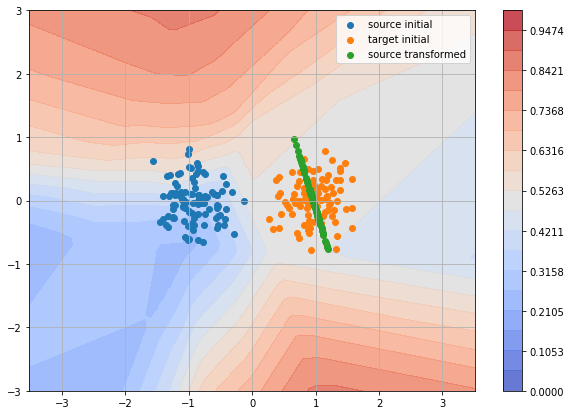

In [108]:
#plt.rcParams['figure.figsize'] = (10, 15)
plt.rcParams['figure.figsize'] = (10, 7)
plt.axes().set_aspect('equal', 'datalim')
plt.axis([-3,3,-3,3])

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = sess.run(D_target, feed_dict={T_input: np.c_[xx.ravel(), yy.ravel()]}).reshape(xx.shape)

#f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[10, 10]})

cont = plt.contourf(xx, yy, Z, levels, cmap=cm, alpha=.8)

plt.scatter(X_source[:,0], X_source[:,1], label="source initial")
plt.scatter(X_target[:,0], X_target[:,1], label="target initial")
plt.scatter(X_source_trans[:,0], X_source_trans[:,1], label="source transformed")

plt.legend()
#cax = f.add_axes([0.91,0.53,0.05,0.35])
# plt.colorbar(cont, cax=cax, orientation="vertical")
plt.colorbar(cont, orientation="vertical")
plt.grid()
#plt.savefig('screenshots/adda-step-77')
#a1.plot(D_loss_list, label="Discriminator loss")
#a1.plot(T_loss_list, label="Generator loss")
#a1.legend()

## Debug

### Learning curve

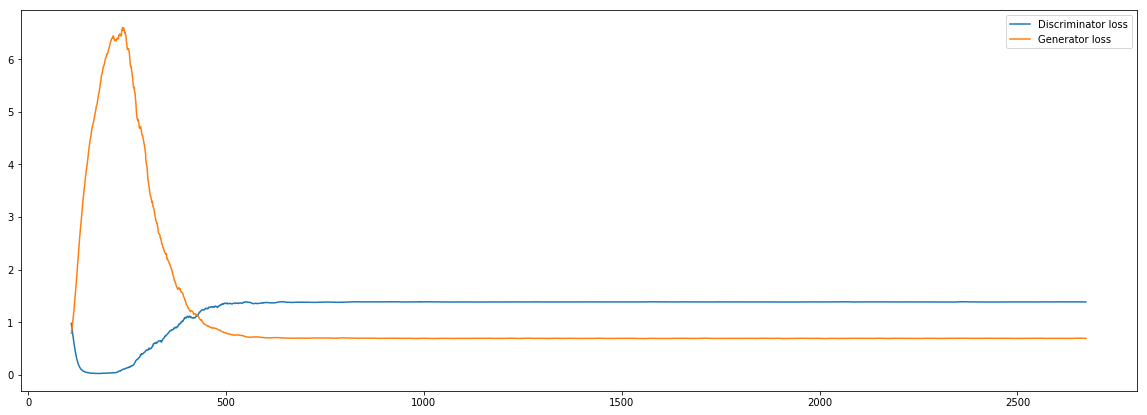

In [109]:
k = 10
def smooth(x_list):
    return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.plot(iter_list[k:-k], smooth(D_loss_list), label="Discriminator loss")
plt.plot(iter_list[k:-k], smooth(G_loss_list), label="Generator loss")
plt.legend()


### Other

In [203]:
sess.run(D_target, feed_dict={T_input: np.array([[0,0]])})

array([[ 0.5]], dtype=float32)

In [335]:
2*np.arange(len(D_loss_list)//2)

array([    0,     2,     4, ..., 10394, 10396, 10398])